In [ ]:
import cv2

from secPysift import *
import numpy as np
import tenseal as ts

IMG_NAME = 'box'
img1 = cv2.imread('box.png', 0)
# resize to 20 x 20
img1 = cv2.resize(img1, (20, 20))

In [ ]:
from matplotlib import pyplot as plt
def plot_image(img, figure_size=(10, 10)):
    # plt.imshow(img, cmap='gray')
    plt.figure(figsize=figure_size)
    plt.show()

plot_image(img1)

In [ ]:
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

secret_key = context.secret_key()
context.make_context_public()

def enc(image):
    enc_img = [[ts.ckks_vector(context=context, vector=[col]) for col in row] for row in image]
    enc_img = np.array(enc_img, dtype=ts.CKKSVector)

    return enc_img

enc_img = enc(img1)

In [ ]:
base_image = secGenerateBaseImage(enc_img, 1.6, 0.5, kernel_size=5)

In [ ]:
def dec(image):
    return np.array([[x.decrypt(secret_key) for x in row] for row in image])

In [ ]:
plot_image(dec(base_image))

In [ ]:
num_octaves = secComputeNumberOfOctaves(img1.shape)
gaussian_kernels = secGenerateGaussianKernels(1.6, 3)

In [ ]:
gaussian_images = secGenerateGaussianImages(base_image, num_octaves, gaussian_kernels)

In [ ]:
for oct in range(num_octaves):
    for i in range(len(gaussian_images[oct])):
        cv2.imwrite(f'{IMG_NAME}-{oct}-{i}.png',dec(gaussian_images[oct][i]))

In [ ]:
gaussian_images = [[cv2.imread(f'{IMG_NAME}-{oct}-{i}.png', 0) for i in range(6)] for oct in range(num_octaves) ]

In [ ]:
for octave in range(num_octaves):
    print(f'Octave {octave + 1}')
    for image in gaussian_images[octave]:
        plot_image(image, figure_size=(5, 5))

In [ ]:
for octave in range(num_octaves):
    print(f'Octave {octave + 1}')
    for i in range(len(gaussian_images[octave])):
        gaussian_images[octave][i] = enc(gaussian_images[octave][i])

In [ ]:
dog_images = secGenerateDoGImages(gaussian_images)

In [ ]:
for oct in range(num_octaves):
    for i in range(len(dog_images[oct])):
        cv2.imwrite(f'dog-{IMG_NAME}-{oct}-{i}.png',dec(dog_images[oct][i]))

In [ ]:
dog_images = [[cv2.imread(f'dog-{IMG_NAME}-{oct}-{i}.png', 0) for i in range(5)] for oct in range(num_octaves) ]

In [ ]:
for octave in range(num_octaves):
    print(f'Octave {octave + 1}')
    for image in dog_images[octave]:
        plot_image(image, figure_size=(5, 5))

In [ ]:
def cmp(x, a, b):
    if isinstance(x, ts.CKKSVector):
        x = x.decrypt(secret_key)[0]
    if isinstance(a, ts.CKKSVector):
        a = a.decrypt(secret_key)[0]
    if isinstance(b, ts.CKKSVector):
        b = b.decrypt(secret_key)[0]
    return ts.ckks_vector(context=context, vector=[int(a < x < b)])
    

In [ ]:
sigma=1.6
num_intervals=3
assumed_blur=0.5
image_border_width=5

In [ ]:
for octave in range(num_octaves):
    for i in range(len(dog_images[octave])):
        dog_images[octave][i] = enc(dog_images[octave][i])

In [ ]:
def refresh(value):
    # print("Value: ", value)
    decrypted_value = value.decrypt(secret_key)[0]
    return ts.ckks_vector(context=context, vector=[decrypted_value])

In [ ]:
keypoints, flat_list = secFindScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, cmp=cmp, refresh=np.vectorize(refresh))

In [ ]:
len(keypoints[0][0])

In [ ]:
def iterimg(imgs):
    for octave in range(num_octaves):
        for i in range(len(imgs[octave])):
            yield np.array(imgs[octave][i])

In [ ]:
count = 0
for kp, img in zip(iterimg(keypoints), iterimg(gaussian_images)):
    # print(kp.shape, (img).shape)
    dec_img = dec(img)
    dec_img = np.array(dec_img, dtype=np.uint8)
    # dec_img = dec_img.squeeze()  
    print(dec_img.shape, dec_img.dtype)
    # Convert image to color image
    dec_img = cv2.cvtColor(dec_img, cv2.COLOR_GRAY2RGB)
    for k in kp.flatten():
        # Set the pixel value to red if it is a keypoint
        dec_img[int(k.i), int(k.j)] = [255, 0, 0] if k.is_keypoint_present.decrypt(secret_key)[0] > 0.5 else dec_img[int(k.i), int(k.j)]
    plot_image(dec_img)

    # Save the image
    cv2.imwrite(f'{IMG_NAME}-keypoints-{count}.png', dec_img)
    count += 1


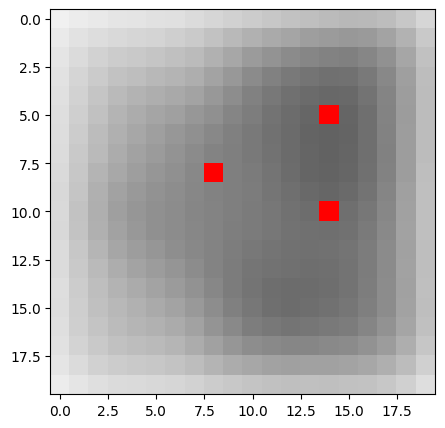

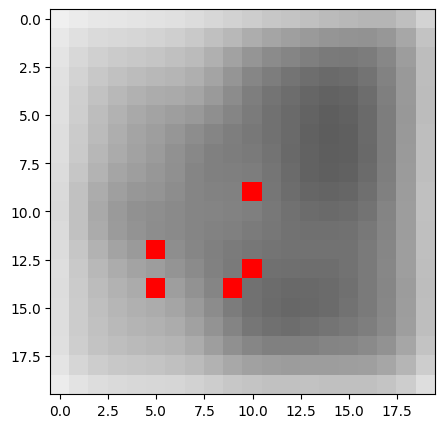

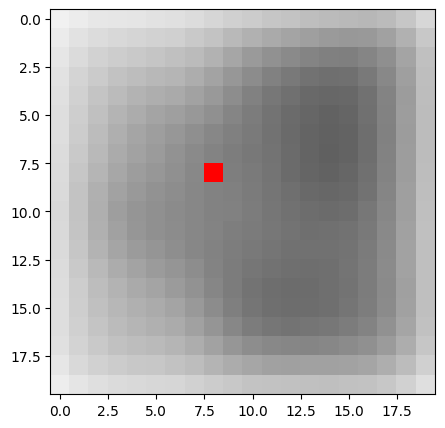

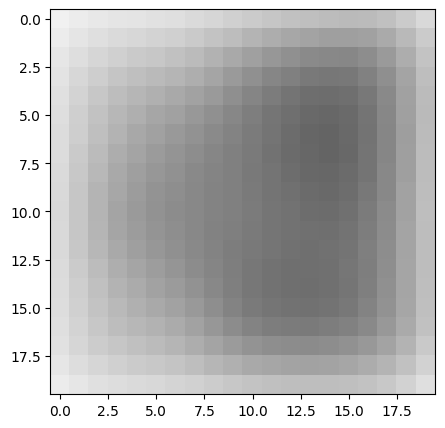

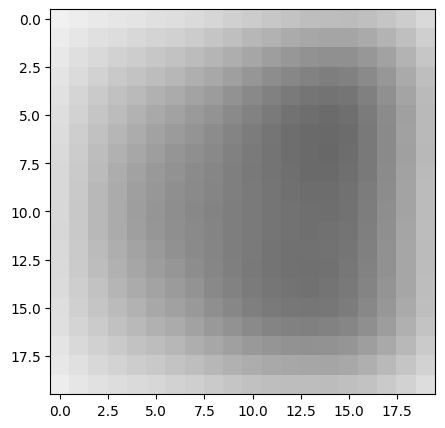

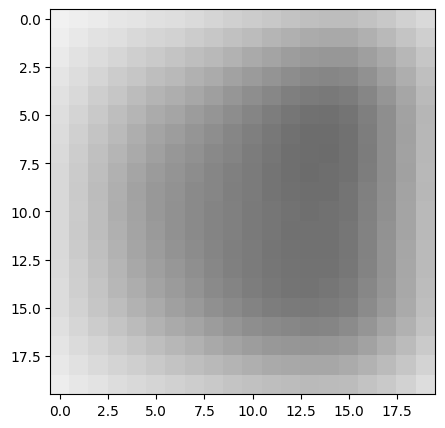

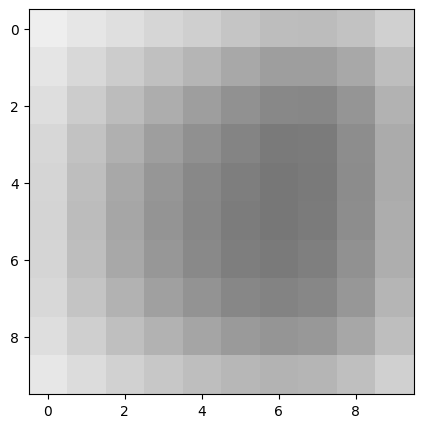

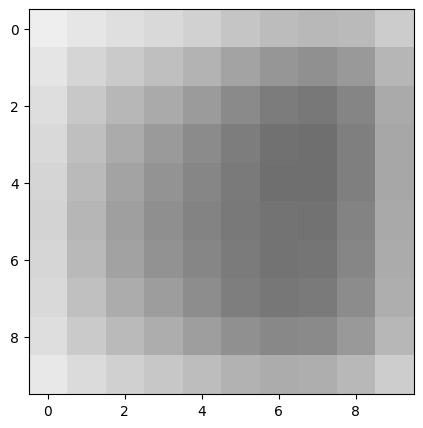

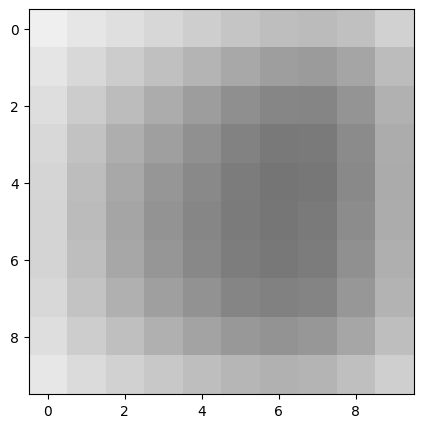

In [5]:
# Read all images with 'box' in the name in this directory, and name them

import cv2
import matplotlib.pyplot as plt
import os
import re

IMG_NAME = 'box'

def get_files():
    files = os.listdir('.')
    files = [f for f in files if re.match(rf'{IMG_NAME}-keypoints-\d+.png', f)]
    return files

files = get_files()

# Sort the files by the number in the filename
files.sort(key=lambda x: int(re.search(rf'{IMG_NAME}-keypoints-(\d+).png', x).group(1)))

# Read the images
images = [cv2.imread(f, 1) for f in files]

def plot_image(img, figure_size=(10, 10)):
    plt.figure(figsize=figure_size)
    plt.imshow(img)
    plt.show()

# Plot the images
for img in images:
    plot_image(img, figure_size=(5, 5))
